1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


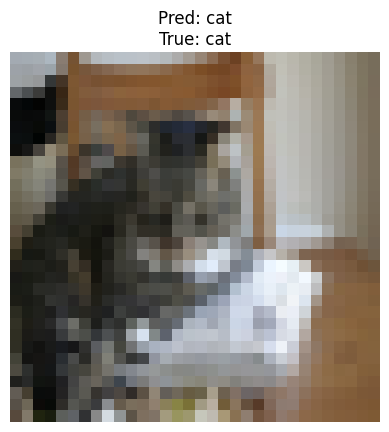

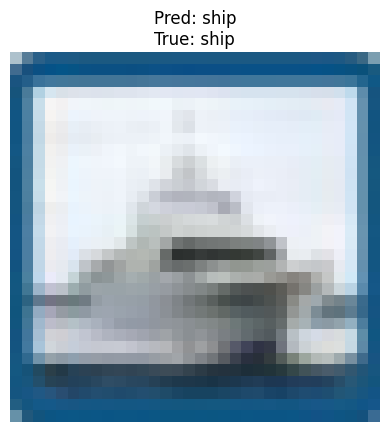

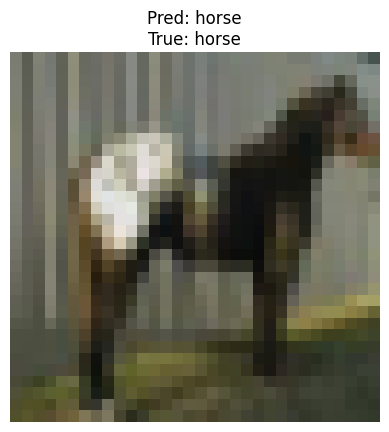

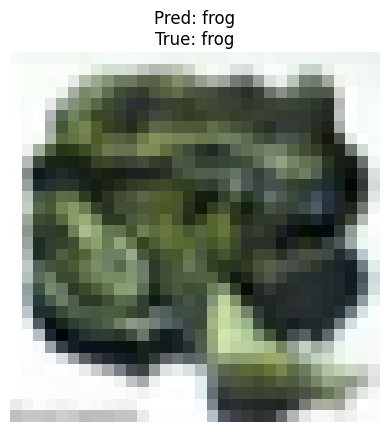

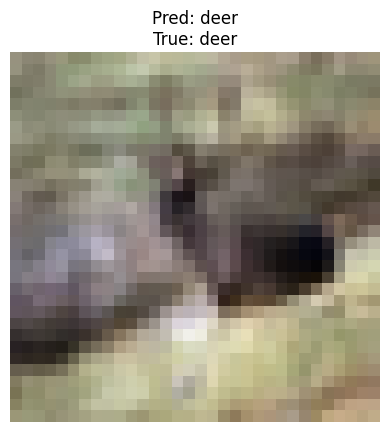

In [13]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# === 1. Load saved model ===

# Set path to directory where files are saved
save_dir = ""

# Load model architecture
with open(os.path.join(save_dir, "model_architecture.txt"), "r") as f:
    model_json = f.read()
model = model_from_json(model_json)

# Load model weights
model.load_weights(os.path.join(save_dir, "model_weights.weights.h5"))

# Compile model with default config for inference
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Load class labels
with open(os.path.join(save_dir, "class_labels.json"), "r") as f:
    class_labels = json.load(f)
class_labels = {int(k): v for k, v in class_labels.items()}

# === 2. Load CIFAR-10 and randomly select 5 images ===
(_, _), (x_test, y_test) = cifar10.load_data()

# Normalize input data
x_test = x_test.astype("float32") / 255.0

# If model expects one-hot labels during training, we only need raw labels for inference

# Random selection
idx = np.random.choice(len(x_test), size=5, replace=False)
sample_images = x_test[idx]
sample_labels = y_test[idx]

# === 3. Run inference ===
predictions = model.predict(sample_images)

# === 4. Show predictions ===
for i in range(5):
    plt.imshow(sample_images[i])
    plt.axis('off')
    pred_class = np.argmax(predictions[i])
    true_class = sample_labels[i][0]
    plt.title(f"Pred: {class_labels.get(pred_class, pred_class)}\nTrue: {class_labels.get(true_class, true_class)}")
    plt.show()

In [20]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# === CONFIG ===
model_arch_file = "model_architecture.txt"
weights_file = "model_weights.weights.h5"
weights_dir = "weights_txt"

# === Step 1: Clean the output folder ===
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)
os.makedirs(weights_dir)

# === Step 2: Load model architecture ===
with open(model_arch_file, "r") as f:
    model_json = f.read()
model = model_from_json(model_json)

# === Step 3: Load weights ===
model.load_weights(weights_file)

# === Step 4: Export weights for each layer ===
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if not weights:
        continue  # Skip layers like Dropout, Pooling, Flatten

    for j, arr in enumerate(weights):
        # Determine the kind of weight
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            kinds = ["gamma", "beta", "moving_mean", "moving_variance"]
            kind = kinds[j]
        else:
            kind = "kernel" if j == 0 else "bias"

        # Save flat weights
        weights_path = os.path.join(weights_dir, f"layer_{i}_{kind}.txt")
        np.savetxt(weights_path, arr.flatten(), fmt="%.18e")

        # Save shape
        shape_path = os.path.join(weights_dir, f"layer_{i}_{kind}_shape.txt")
        with open(shape_path, "w") as f:
            f.write(" ".join(map(str, arr.shape)))

print(f"✅ All layer weights exported to '{weights_dir}' as plain .txt files.")


✅ All layer weights exported to 'weights_txt' as plain .txt files.


In [21]:
!ls weights_txt/

layer_0_bias_shape.txt		    layer_20_moving_mean_shape.txt
layer_0_bias.txt		    layer_20_moving_mean.txt
layer_0_kernel_shape.txt	    layer_20_moving_variance_shape.txt
layer_0_kernel.txt		    layer_20_moving_variance.txt
layer_12_bias_shape.txt		    layer_22_bias_shape.txt
layer_12_bias.txt		    layer_22_bias.txt
layer_12_kernel_shape.txt	    layer_22_kernel_shape.txt
layer_12_kernel.txt		    layer_22_kernel.txt
layer_13_beta_shape.txt		    layer_2_bias_shape.txt
layer_13_beta.txt		    layer_2_bias.txt
layer_13_gamma_shape.txt	    layer_2_kernel_shape.txt
layer_13_gamma.txt		    layer_2_kernel.txt
layer_13_moving_mean_shape.txt	    layer_3_beta_shape.txt
layer_13_moving_mean.txt	    layer_3_beta.txt
layer_13_moving_variance_shape.txt  layer_3_gamma_shape.txt
layer_13_moving_variance.txt	    layer_3_gamma.txt
layer_14_bias_shape.txt		    layer_3_moving_mean_shape.txt
layer_14_bias.txt		    layer_3_moving_mean.txt
layer_14_kernel_shape.txt	    layer_3_moving_variance_shape.txt
layer_14

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


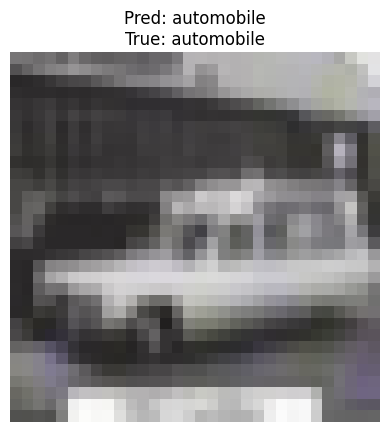

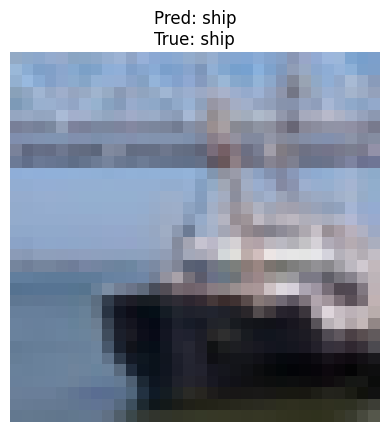

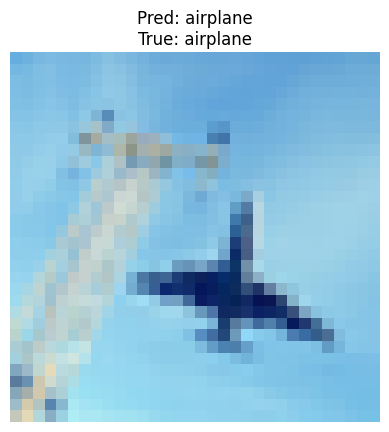

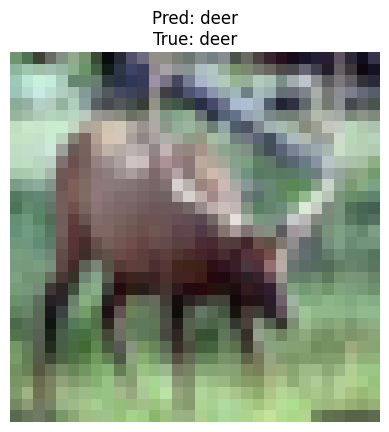

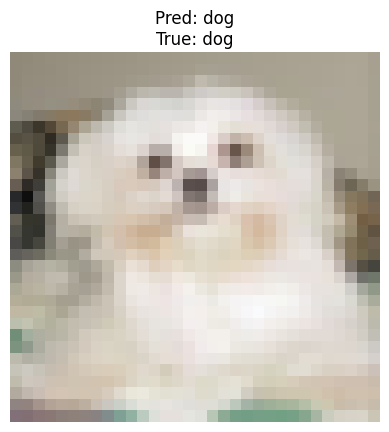

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# === CONFIG ===
weights_dir = "weights_txt"

# === Hardcoded class labels ===
class_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

# === Rebuild model architecture (must match training) ===
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# === Load weights from .txt files ===
def load_weights_from_txt(model, weights_dir):
    for i, layer in enumerate(model.layers):
        weights = []

        # BatchNorm layers: 4 params
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            for kind in ["gamma", "beta", "moving_mean", "moving_variance"]:
                shape_file = os.path.join(weights_dir, f"layer_{i}_{kind}_shape.txt")
                data_file = os.path.join(weights_dir, f"layer_{i}_{kind}.txt")

                with open(shape_file, "r") as f:
                    shape = tuple(map(int, f.read().split()))
                arr = np.loadtxt(data_file).reshape(shape)
                weights.append(arr)

        # Conv2D / Dense: kernel + bias
        elif isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
            for kind in ["kernel", "bias"]:
                shape_file = os.path.join(weights_dir, f"layer_{i}_{kind}_shape.txt")
                data_file = os.path.join(weights_dir, f"layer_{i}_{kind}.txt")

                with open(shape_file, "r") as f:
                    shape = tuple(map(int, f.read().split()))
                arr = np.loadtxt(data_file).reshape(shape)
                weights.append(arr)

        # Set weights if applicable
        if weights:
            layer.set_weights(weights)

# === Load test images from CIFAR-10 ===
(_, _), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype("float32") / 255.0

# Pick 5 random samples
indices = np.random.choice(len(x_test), 5, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# === Build and load model ===
model = build_model()
load_weights_from_txt(model, weights_dir)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Run inference ===
predictions = model.predict(sample_images)

# === Display results ===
for i in range(5):
    plt.imshow(sample_images[i])
    plt.axis('off')
    pred_class = np.argmax(predictions[i])
    true_class = sample_labels[i][0]
    plt.title(f"Pred: {class_labels[pred_class]}\nTrue: {class_labels[true_class]}")
    plt.show()

In [23]:
import os
import zipfile

weights_dir = "weights_txt"
zip_filename = "weights_txt.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(weights_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=weights_dir)
            zipf.write(file_path, arcname)

print(f"✅ Zipped all files in '{weights_dir}' to '{zip_filename}'")

✅ Zipped all files in 'weights_txt' to 'weights_txt.zip'
